# Installation 

Git clone and install packages if not yet done.

In [ ]:
import os

if os.path.exists('nodegam'):
    os.chdir('nodegam')
else:
    !git clone https://github.com/zzzace2000/nodegam
    os.chdir('nodegam')

Cloning into 'nodegam'...
remote: Enumerating objects: 207, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 207 (delta 126), reused 153 (delta 72), pack-reused 0
Receiving objects: 100% (207/207), 6.75 MiB | 10.87 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [ ]:
try:
    import nodegam
except ImportError:
    !pip install -r requirements.txt
    print('After installation, stopping RUNTIME! Please run again.')
    os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
     |████████████████████████████████| 125 kB 63.2 MB/s 
     |████████████████████████████████| 69 kB 7.8 MB/s 
     |████████████████████████████████| 1.8 MB 63.7 MB/s 
     |████████████████████████████████| 6.6 MB 47.4 MB/s 
     |████████████████████████████████| 569 kB 51.8 MB/s 
     |████████████████████████████████| 275 kB 58.5 MB/s 
     |████████████████████████████████| 133 kB 62.7 MB/s 
     |████████████████████████████████| 793 kB 65.7 MB/s 
     |████████████████████████████████| 9.8 MB 33.3 MB/s 
     |████████████████████████████████| 3.6 MB 51.9 MB/s 
     |████████████████████████████████| 5.8 MB 60.2 MB/s 
     |████████████████████████████████| 281 kB 73.8 MB/s 
     |████████████████████████████████| 756 kB 75.8 MB/s 
     |████████████████████████████████| 251 kB 72.7 MB/s 
     |███████████████████████████

In [ ]:
!ls

# Main code

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import argparse
import json
import os
import pickle
import shutil
import sys
import time
from os.path import join as pjoin, exists as pexists
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

if pexists('nodegam'):
  os.chdir('nodegam')

import nodegam

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


WARNING! The apex is not installed so fp16 is not available.


In [3]:
# Only use GPU 0
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
name = 'bikeshare_ga2m_{}.{:0>2d}.{:0>2d}_{:0>2d}:{:0>2d}'.format(*time.gmtime()[:5])
name

'bikeshare_ga2m_2022.06.23_18:36'

We use the best hyperparameters for NODE-GA2M in bikeshare to demonstrate. You can see all hyperparameters here by loading the following:

In [5]:
# with open('best_hparams/node_ga2m/0519_f0_best_bikeshare_GAM_ga2m_s83_nl4_nt125_td1_d6_od0.0_ld0.3_cs0.5_lr0.01_lo0_la0.0_pt0_pr0_mn0_ol0_ll1') as fp:
#     hparams = json.load(fp)

In [6]:
# Create directory
os.makedirs(pjoin('logs', name), exist_ok=True)

# Set seed
nodegam.utils.seed_everything(seed=83)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
# Generate dataset
N = 25000
x1 = np.random.uniform(-5, 5, size=N)
x2 = np.random.uniform(-5, 5, size=N)
x3 = np.random.uniform(-5, 5, size=N)

f1 = lambda x: (x) ** 2 - 8
f2 = lambda x: x * 2
f3 = lambda x: np.sin(x)

y = f1(x1) + f2(x2) + f3(x3)
X = pd.DataFrame(np.vstack([x1, x2, x3]).T)
X.shape, y.shape

((25000, 3), (25000,))

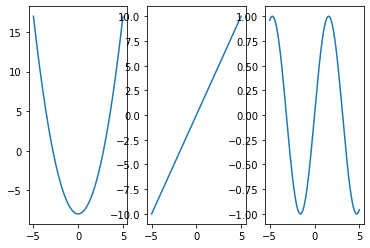

In [8]:
x = np.linspace(-5, 5, 1000)
fig, ax = plt.subplots(1, 3)
ax[0].plot(x, f1(x))
ax[1].plot(x, f2(x))
ax[2].plot(x, f3(x))

In [9]:
# data = nodegam.data.DATASETS['BIKESHARE'](path='./data', fold=0)

# Data
preprocessor = nodegam.data.MyPreprocessor(
    cat_features=None,
    y_normalize=True,  #True if regression, False for classification
    random_state=1337, quantile_transform=False,
    output_distribution="uniform",
)

problem = "regression"

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1377)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, train_size=0.8, random_state=1377)

preprocessor.fit(X, y)

# Transform dataset
X_train, y_train = preprocessor.transform(X_train, y_train)
X_valid, y_valid = preprocessor.transform(X_valid, y_valid)
X_test, y_test = preprocessor.transform(X_test, y_test)

Normalize y. mean = 0.2873875263188871, std = 9.428513973462028


In [10]:
X_train.shape, X_valid.shape, X_test.shape

((16000, 3), (4000, 3), (5000, 3))

In [11]:
choice_fn = nodegam.nn_utils.EM15Temp(max_temp=1., min_temp=0.01, steps=4000)

# Temperature annealing for entmoid
model = nodegam.arch.GAMBlock(
    in_features=X_train.shape[1],
    num_trees=125,
    num_layers=4,
    num_classes=1,
    addi_tree_dim=1,
    depth=6,
    choice_function=choice_fn,
    bin_function=nodegam.nn_utils.entmoid15,
    output_dropout=0.0,
    last_dropout=0.3,
    colsample_bytree=0.5,
    selectors_detach=0, # This is only used to save memory in large datasets like epsilon
    add_last_linear=True,
    ga2m=1,
    l2_lambda=0.0,
)

step_callbacks = [choice_fn.temp_step_callback]

/content/nodegam/nodegam/odst.py:106: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)


In [12]:
model.to(device)

GAMBlock(
  (0): GAM_ODST(input_dim=3, num_trees=125, depth=6, tree_dim=2)
  (1): GAM_ODST(input_dim=3, num_trees=125, depth=6, tree_dim=2)
  (2): GAM_ODST(input_dim=3, num_trees=125, depth=6, tree_dim=2)
  (3): GAM_ODST(input_dim=3, num_trees=125, depth=6, tree_dim=2)
)

In [13]:
from qhoptim.pyt import QHAdam
optimizer_params = {'nus': (0.7, 1.0), 'betas': (0.95, 0.998)}

trainer = nodegam.trainer.Trainer(
    model=model,
    experiment_name=name,
    warm_start=True, # if True, will load latest checkpt in the saved dir logs/${name}
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    lr=0.01,
    lr_warmup_steps=500,
    verbose=False,
    n_last_checkpoints=5,
    step_callbacks=step_callbacks, # Temp annelaing
    fp16=1,
    problem='regression',
)

In [14]:
batch_size = 2048

# trigger data-aware init
with torch.no_grad():
    res = model(torch.as_tensor(X_train[:(2 * batch_size)], device=device))

Train around 35 minutes. It actually converges around 6000 steps. Can stop early but just has a high number to make sure it converges.

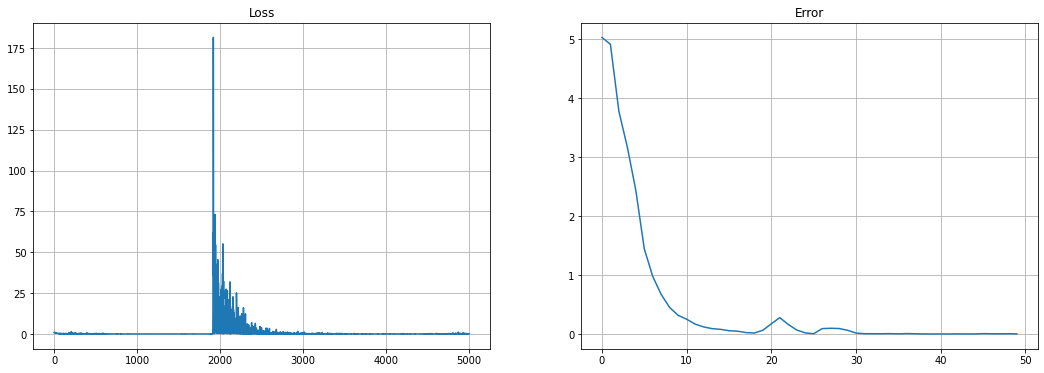

BREAK. There is no improvment for 1000 steps
Best step:  4200
Best Val Error:  0.00043769068744736186


In [15]:
loss_history, err_history = [], []
report_frequency = 100
best_err, best_step_err = np.inf, -1
early_stopping_rounds = 1000
lr_decay_steps = 5000
prev_lr_decay_step = 0
max_rounds = -1 # No max round set
max_time = 3600 * 10 # 10 hours

st_time = time.time()
for batch in nodegam.utils.iterate_minibatches(X_train, y_train,
                                               batch_size=batch_size,
                                               shuffle=True, epochs=float('inf')):
    metrics = trainer.train_on_batch(*batch, device=device)

    loss_history.append(float(metrics['loss']))

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.remove_old_temp_checkpoints()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')

        err = trainer.evaluate_mse(X_valid, y_valid, device=device, batch_size=batch_size * 2)
        if err < best_err:
            best_err = err
            best_step_err = trainer.step
            trainer.save_checkpoint(tag='best')
        err_history.append(err)

        trainer.load_checkpoint()  # last
        
        # Plot loss curve
        clear_output(True)
        plt.figure(figsize=[18, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.title('Loss')
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(err_history)
        plt.title('Error')
        plt.grid()
        plt.show()

    if trainer.step > 4000 + early_stopping_rounds: # Stop training at least running 4k steps: the steps for temperature annealing
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        break

    if lr_decay_steps > 0 \
            and trainer.step > best_step_err + lr_decay_steps \
            and trainer.step > (prev_lr_decay_step + lr_decay_steps):
        lr_before = trainer.lr
        trainer.decrease_lr(ratio=0.2, min_lr=1e-6)
        prev_lr_decay_step = trainer.step
        print('LR: %.2e -> %.2e' % (lr_before, trainer.lr))

    if 0 < max_rounds < trainer.step:
        print('End. It reaches the maximum rounds %d' % max_rounds)
        break

    if (time.time() - st_time) > max_time:
        print('End. It reaches the maximum run time %d (s)' % max_time)
        break

print("Best step: ", best_step_err)
print("Best Val Error: ", best_err)

In [16]:
max_step = trainer.step
trainer.load_checkpoint(tag='best')
test_err = trainer.evaluate_mse(X_test, y_test, device=device, batch_size=2 * batch_size)

print("Test Error rate: {}".format(test_err))

# Clean up
trainer.remove_old_temp_checkpoints(number_ckpts_to_keep=0)

Test Error rate: 0.0004577406323956927


In [17]:
preprocessor.y_std

9.428513973462028

In [18]:
print("The unnormalized RMSE: {}".format(np.sqrt(test_err * (preprocessor.y_std) ** 2)))

The unnormalized RMSE: 0.20172186823144628


Then we visualize this model

In [19]:
os.listdir(f'logs/{name}')

['checkpoint_avg.pth', 'checkpoint_best.pth']

In [21]:
max_n_bins = 256

# all_X = pd.concat(X, data['X_test']], axis=0)
all_X = X

if max_n_bins is not None and max_n_bins > 0:
    all_X = nodegam.gams.utils.bin_data(all_X, max_n_bins=max_n_bins)

df = model.extract_additive_terms(all_X, norm_fn=preprocessor.transform, y_mu=preprocessor.y_mu, 
                                  y_std=preprocessor.y_std,
                                  device=device, batch_size=2*batch_size)

bin features 0 with uniq val 24990 to only 256
bin features 1 with uniq val 24991 to only 256
bin features 2 with uniq val 24994 to only 256
Finish "Run values through model" in 336ms


100%|██████████| 6/6 [00:00<00:00, 84.58it/s]


Finish "Extract values" in 79ms
Finish "Purify interactions to main effects" in 73ms
Finish "Center main effects" in 1ms


100%|██████████| 7/7 [00:00<00:00, 24.55it/s]

Finish "Construct table" in 295ms


Here we visualize the main effects

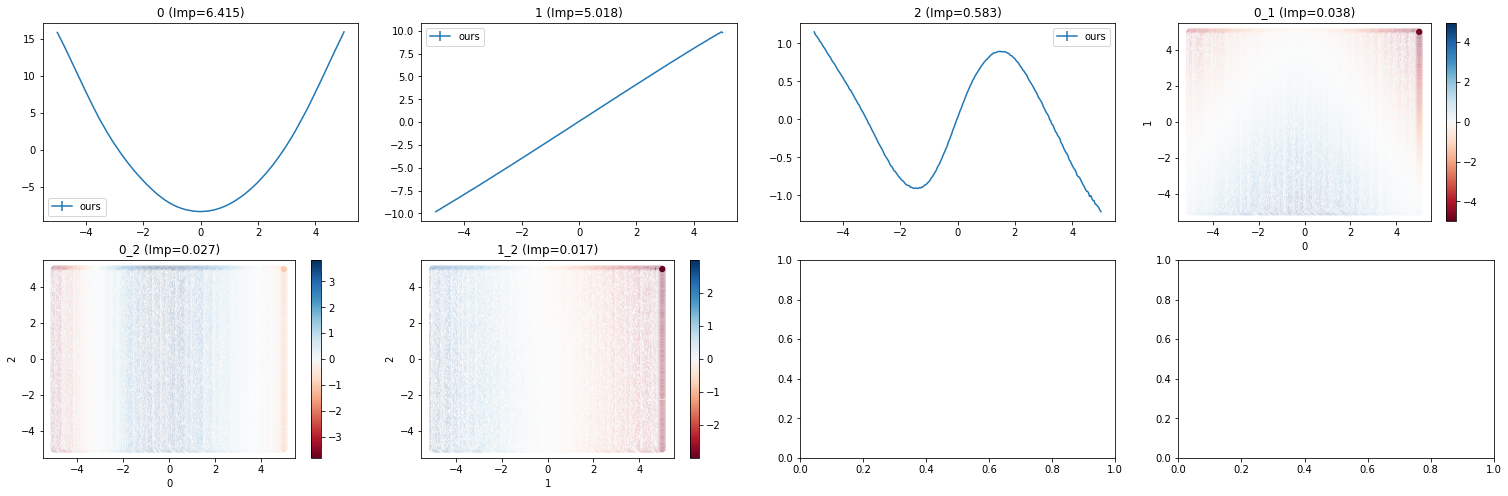

In [22]:
from nodegam.gams import vis_utils
fig, axes = vis_utils.vis_main_effects({'ours': df}, show_density=False)

Roughly right. See the ground truth below.

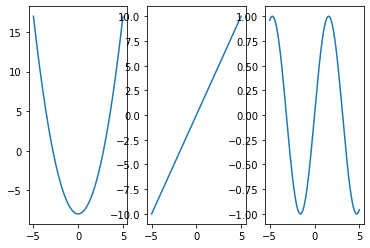

In [23]:
x = np.linspace(-5, 5, 1000)
fig, ax = plt.subplots(1, 3)
ax[0].plot(x, f1(x))
ax[1].plot(x, f2(x))
ax[2].plot(x, f3(x))

Save dataframe

In [ ]:
# with open('gam_df.pkl', 'wb') as op:
#     pickle.dump(df, op, protocol=pickle.HIGHEST_PROTOCOL)